## Setting seeds.

In [1]:
import torch, random, numpy as np, os, platform

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = True


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


## Copy the dataset into current session (Already downloaded into google drive)

In [24]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:

import pathlib, shutil, subprocess, os, sys, zipfile, textwrap

DRIVE_ZIP = "/content/drive/MyDrive/mohantydataset/PlantVillageDataset.zip"
LOCAL_ZIP = "/content/PlantVillageDataset.zip"
EXTRACT_TO = "/content/PlantVillage"

if not pathlib.Path(DRIVE_ZIP).exists():
    raise FileNotFoundError(f"{DRIVE_ZIP} not found. Double-check the path in Drive.")
print("Copying ZIP from Drive -> local runtime ")
shutil.copy2(DRIVE_ZIP, LOCAL_ZIP)

size_mb = pathlib.Path(LOCAL_ZIP).stat().st_size / 1_048_576
print(f"Local copy size: {size_mb:.1f} MB")

# Quick integrity test
print("Testing archive integrity …")
if not zipfile.is_zipfile(LOCAL_ZIP):
    raise RuntimeError("Python thinks this is not a valid ZIP, check the file.")
with zipfile.ZipFile(LOCAL_ZIP) as zf:
    bad = zf.testzip()
if bad:
    raise RuntimeError(f"Corrupted member detected: {bad}. The ZIP may still be incomplete.")

shutil.rmtree(EXTRACT_TO, ignore_errors=True)
pathlib.Path(EXTRACT_TO).mkdir(parents=True, exist_ok=True)
print("Extracting (this can take several minutes)")
with zipfile.ZipFile(LOCAL_ZIP) as zf:
    zf.extractall(EXTRACT_TO)
print("Extraction complete.")

# List potential class-folder root that has ~38 subdirs
for root, dirs, files in os.walk(EXTRACT_TO):
    if dirs and len(dirs) >= 30:
        sample = dirs[:10]
        print(f"\nFound candidate root: {root}  ->  {len(dirs)} sub-folders (first 10 shown)")
        print("   ", sample)
        break


Copying ZIP from Drive -> local runtime 
Local copy size: 841.2 MB
Testing archive integrity …
Extracting (this can take several minutes)
Extraction complete.

Found candidate root: /content/PlantVillage/color  ->  38 sub-folders (first 10 shown)
    ['Grape___Black_rot', 'Tomato___Target_Spot', 'Grape___Esca_(Black_Measles)', 'Potato___Late_blight', 'Apple___Cedar_apple_rust', 'Corn_(maize)___Northern_Leaf_Blight', 'Strawberry___healthy', 'Tomato___Leaf_Mold', 'Pepper,_bell___Bacterial_spot', 'Blueberry___healthy']


## Data Preprocessing

In [27]:

import shutil, sys, importlib.util, pathlib, os, time

DRIVE_SCRIPT = "/content/drive/MyDrive/mohantydataset/preprocess.py"
LOCAL_SCRIPT = "/content/preprocess.py"

if not pathlib.Path(LOCAL_SCRIPT).exists():
    if pathlib.Path(DRIVE_SCRIPT).exists():
        shutil.copy2(DRIVE_SCRIPT, LOCAL_SCRIPT)
        print("Copied preprocess.py from Drive to /content/")
    else:
        raise FileNotFoundError(
            "preprocess.py not found. Upload it to /content/ or adjust DRIVE_SCRIPT path."
        )

if "/content" not in sys.path:
    sys.path.append("/content")

import preprocess as pp

pp.SOURCE_DATA_ROOT  = "/content/PlantVillage/color"
pp.OUTPUT_DATA_ROOT  = "/content/PlantVillage_Organized_299"
pp.TARGET_IMG_WIDTH  = 299
pp.TARGET_IMG_HEIGHT = 299
pp.TARGET_IMG_SIZE   = (299, 299)

pp.CLASS_LABELS = sorted(
    d for d in os.listdir(pp.SOURCE_DATA_ROOT)
    if os.path.isdir(os.path.join(pp.SOURCE_DATA_ROOT, d))
)

print(f"{len(pp.CLASS_LABELS)} classes detected.")
print("Images will be resized to", pp.TARGET_IMG_SIZE)

start = time.perf_counter()
pp.distribute_dataset(
    pp.SOURCE_DATA_ROOT,
    pp.OUTPUT_DATA_ROOT,
    pp.CLASS_LABELS,
    pp.TRAIN_SPLIT_RATIO,
    pp.TARGET_IMG_SIZE
)
print(f"\nPreprocessing finished in {time.perf_counter() - start:.1f}s")
print("   Train folder:", pp.OUTPUT_DATA_ROOT + "/train")
print("   Val   folder:", pp.OUTPUT_DATA_ROOT + "/test")


Copied preprocess.py from Drive to /content/
38 classes detected.
Images will be resized to (299, 299)
Created base directories: /content/PlantVillage_Organized_299/train and /content/PlantVillage_Organized_299/test

Starting dataset distribution and initial image processing...
Images will be resized to 299x299 pixels and converted to RGB.
Please note: Full pixel value normalization (mean/std subtraction) is *not* done here.
That crucial step should still be performed dynamically during PyTorch data loading.


Processing classes: 100%|██████████| 38/38 [03:17<00:00,  5.20s/it]


Dataset distribution and initial processing complete! Total files processed: 54305
Organized and resized dataset saved to: /content/PlantVillage_Organized_299
Important Reminder: Final pixel normalization (mean/std subtraction) and data augmentation
should be applied by `torchvision.transforms` in your PyTorch training script during data loading.

Preprocessing finished in 197.5s
   Train folder: /content/PlantVillage_Organized_299/train
   Val   folder: /content/PlantVillage_Organized_299/test


## Building DataLoaders for InceptionV3

38 classes | 43429 train images | 10876 val images


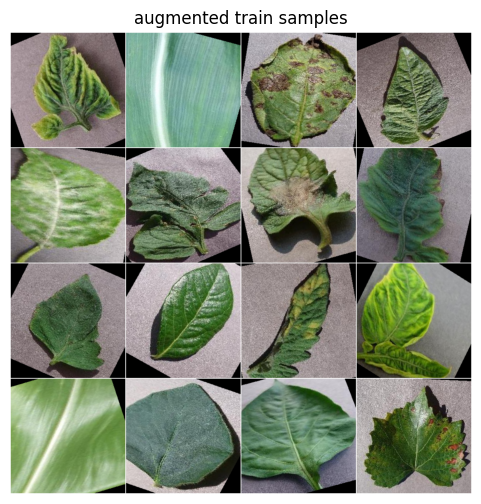

In [29]:

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch, matplotlib.pyplot as plt, torchvision

DATA_ROOT = "/content/PlantVillage_Organized_299"
IMG_HEIGHT = IMG_WIDTH = 299
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225])
    ]),
}

train_ds = datasets.ImageFolder(f"{DATA_ROOT}/train", transform=data_transforms['train'])
val_ds   = datasets.ImageFolder(f"{DATA_ROOT}/test",  transform=data_transforms['val'])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2,
                          shuffle=False, num_workers=4, pin_memory=True)

class_names = train_ds.classes
print(f"{len(class_names)} classes | {len(train_ds)} train images | {len(val_ds)} val images")

inv_norm = transforms.Normalize([-m/s for m, s in zip([0.485,0.456,0.406],
                                                      [0.229,0.224,0.225])],
                                [1/s for s in [0.229,0.224,0.225]])
imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(inv_norm(imgs[:16]), nrow=4, pad_value=1)
plt.figure(figsize=(6,6)); plt.imshow(grid.permute(1,2,0)); plt.axis("off")
plt.title("augmented train samples"); plt.show()


## Training script for inceptionV3



In [37]:

import torch, torch.nn as nn, torch.optim as optim
from torchvision import models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np, os

#  hyper-params (same as ResNet script)
GRADIENT_ACCUMULATION_STEPS = 4
EPOCHS  = 10
LR      = 1e-3
MODEL_SAVE_PATH = "best_inceptionv3_plant_disease_model.pth"
ACC_STEPS = 4
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on:", device)

# model factory
def get_inception_v3_model(num_classes):
    model = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)
    for p in model.parameters():
        p.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    return model.to(device)

model_ft = get_inception_v3_model(len(class_names))


Running on: cuda



Epoch 1/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 2.7849  Acc: 0.6967


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.6850  Acc: 0.8430
New best val acc 0.8430 — model saved

Epoch 2/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 2.1203  Acc: 0.8313


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.5082  Acc: 0.8722
New best val acc 0.8722 — model saved

Epoch 3/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 2.0168  Acc: 0.8472


val:   0%|          | 0/170 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798953fec400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798953fec400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

val   Loss: 0.4314  Acc: 0.8832
New best val acc 0.8832 — model saved

Epoch 4/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9759  Acc: 0.8551


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.3694  Acc: 0.9011
New best val acc 0.9011 — model saved

Epoch 5/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9518  Acc: 0.8603


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.3376  Acc: 0.9058
New best val acc 0.9058 — model saved

Epoch 6/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9335  Acc: 0.8636


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.3359  Acc: 0.9009

Epoch 7/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9200  Acc: 0.8661


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.3137  Acc: 0.9075
New best val acc 0.9075 — model saved

Epoch 8/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798953fec400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x798953fec400>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^

train Loss: 1.9206  Acc: 0.8665


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.2981  Acc: 0.9133
New best val acc 0.9133 — model saved

Epoch 9/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9197  Acc: 0.8654


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.3059  Acc: 0.9076

Epoch 10/10
------------------------------


train:   0%|          | 0/1358 [00:00<?, ?it/s]

train Loss: 1.9061  Acc: 0.8689


val:   0%|          | 0/170 [00:00<?, ?it/s]

val   Loss: 0.2919  Acc: 0.9119


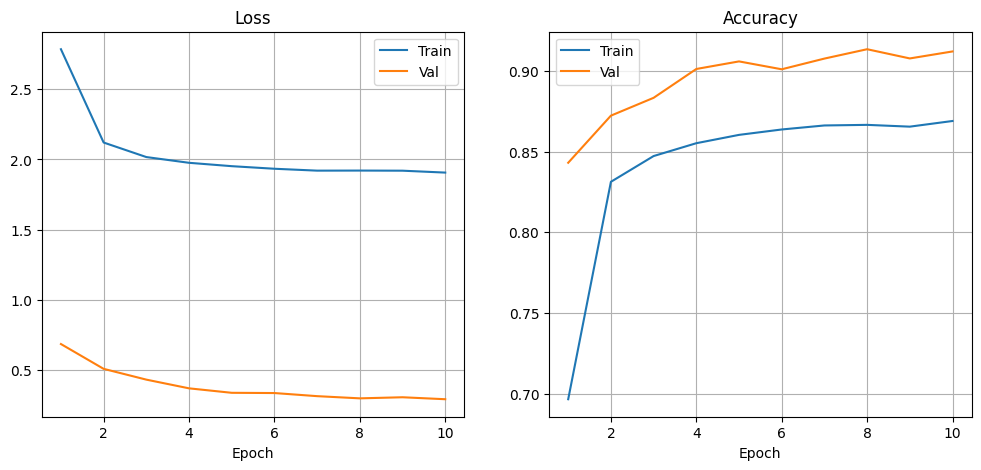

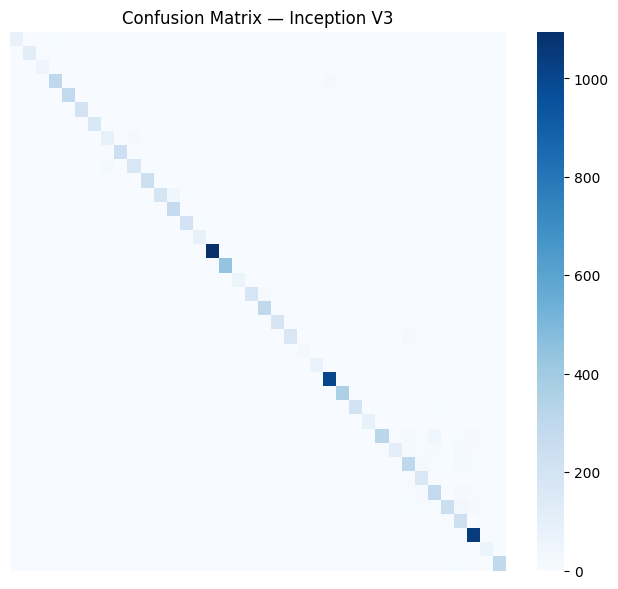


Best validation accuracy: 0.9133


In [38]:
def build_model(num_classes: int):
    m = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)
    for p in m.parameters():
        p.requires_grad = False
    m.fc           = nn.Linear(m.fc.in_features,           num_classes)
    m.AuxLogits.fc = nn.Linear(m.AuxLogits.fc.in_features, num_classes)
    return m.to(device)

model = build_model(len(class_names))
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.fc.parameters(), lr=LR)

def train_model(model, loaders, sizes, epochs=10, model_save_path="best_inceptionv3.pt"):
    hist = {k: [] for k in ['train_loss','train_acc','val_loss','val_acc']}
    best_acc = 0.0

    for ep in range(epochs):
        print(f"\nEpoch {ep+1}/{epochs}\n" + "-"*30)
        for phase in ['train','val']:
            model.train() if phase=='train' else model.eval()
            run_loss, run_corrects = 0.0, 0
            if phase=='val': all_preds, all_labels = [], []

            for i,(x,y) in enumerate(tqdm(loaders[phase], desc=phase)):
                x, y = x.to(device), y.to(device)
                with torch.set_grad_enabled(phase=='train'):
                    if phase=='train':
                        out, aux = model(x)
                        loss = criterion(out,y)+0.4*criterion(aux,y)
                    else:
                        out = model(x);  loss = criterion(out,y)
                    preds = out.argmax(1)

                    if phase=='train':
                        (loss/ACC_STEPS).backward()
                        if (i+1)%ACC_STEPS==0: optimizer.step(); optimizer.zero_grad()

                run_loss   += loss.item()*x.size(0)
                run_corrects += (preds==y).sum().item()
                if phase=='val':
                    all_preds.extend(preds.cpu().numpy()); all_labels.extend(y.cpu().numpy())

            if phase=='train' and (i+1)%ACC_STEPS: optimizer.step(); optimizer.zero_grad()
            epoch_loss = run_loss / sizes[phase];  epoch_acc = run_corrects / sizes[phase]
            print(f"{phase:5s} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
            hist[f'{phase}_loss'].append(epoch_loss);  hist[f'{phase}_acc'].append(epoch_acc)

            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), model_save_path)
                print(f"New best val acc {best_acc:.4f} — model saved")

    return hist, all_preds, all_labels


MODEL_PATH = "best_inceptionv3_plant_disease_model.pth"

loaders = {'train': train_loader, 'val': val_loader}
sizes   = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

history, val_preds, val_labels = train_model(
    model, loaders, sizes, epochs=EPOCHS, model_save_path=MODEL_PATH
)

epochs = range(1, EPOCHS+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(epochs, history['train_loss'], label='Train'); plt.plot(epochs, history['val_loss'], label='Val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2); plt.plot(epochs, history['train_acc'], label='Train'); plt.plot(epochs, history['val_acc'], label='Val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
plt.show()

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8,7))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix — Inception V3"); plt.show()
print(f"\nBest validation accuracy: {max(history['val_acc']):.4f}")


## Creating plots and displaying classification metrics for the best model

In [43]:
val_preds, val_labels = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="inference"):
        x = x.to(device)
        out = model_eval(x)          # one tensor in eval mode
        val_preds.extend(out.argmax(1).cpu().numpy())
        val_labels.extend(y.numpy())

class_names = val_loader.dataset.classes
print("Validation inference complete")


inference:   0%|          | 0/170 [00:00<?, ?it/s]

Validation inference complete


## Confusion matrix (per class)

Text(0, 0.5, 'True')

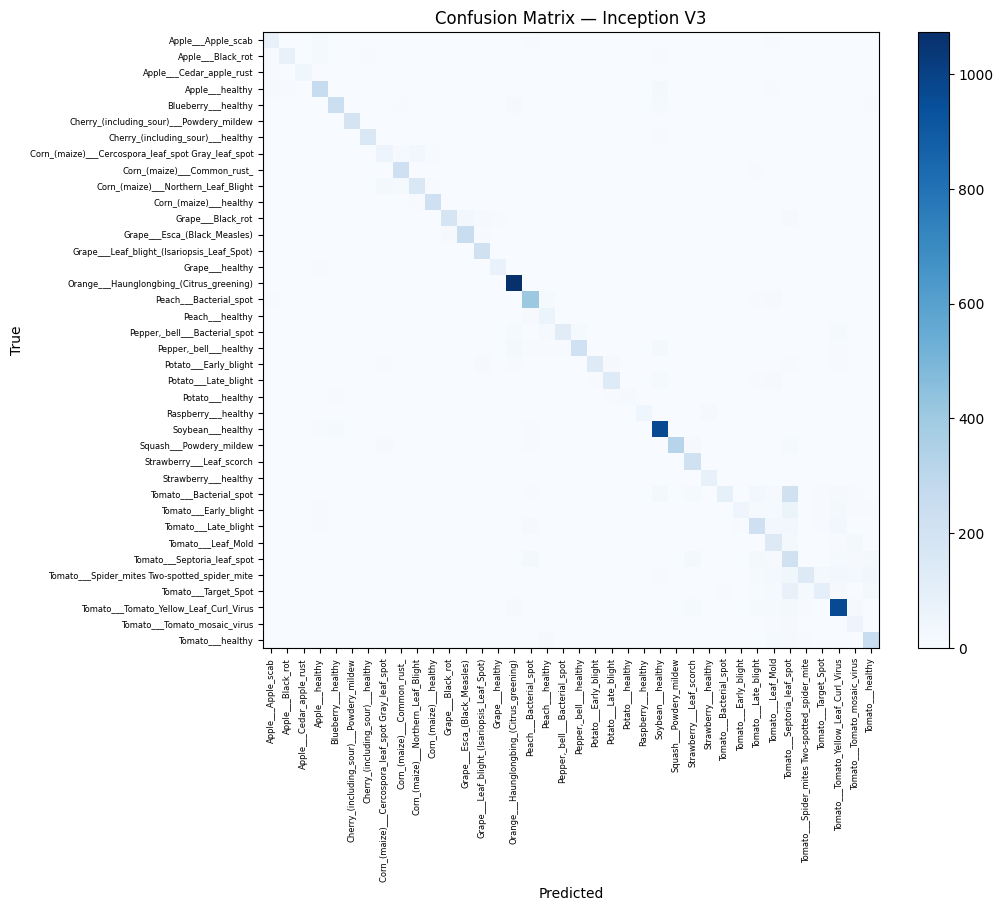

In [46]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix — Inception V3")
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90, fontsize=6)
plt.yticks(ticks, class_names, fontsize=6)
plt.xlabel("Predicted"); plt.ylabel("True")




In [47]:
#  metrics table
report = classification_report(val_labels, val_preds,
                               target_names=class_names, output_dict=True)
df = pd.DataFrame(report).T

# add per-class accuracy (only to class rows)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
df.loc[class_names, "accuracy_per_class"] = per_class_acc

print("\nPrecision / Recall / F1 / Support and per-class accuracy")
display(df.round(4))


Precision / Recall / F1 / Support and per-class accuracy


,precision,recall,f1-score,support,accuracy_per_class
Apple___Apple_scab,0.5603,0.6270,0.5918,126.0000,0.6270
Apple___Black_rot,0.7383,0.6320,0.6810,125.0000,0.6320
Apple___Cedar_apple_rust,0.6508,0.7455,0.6949,55.0000,0.7455
Apple___healthy,0.7385,0.7812,0.7592,329.0000,0.7812
Blueberry___healthy,0.8204,0.7741,0.7966,301.0000,0.7741
Cherry_(including_sour)___Powdery_mildew,0.9635,0.8768,0.9181,211.0000,0.8768
Cherry_(including_sour)___healthy,0.8370,0.9006,0.8676,171.0000,0.9006
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.5638,0.5146,0.5381,103.0000,0.5146
Corn_(maize)___Common_rust_,0.8014,0.9456,0.8676,239.0000,0.9456
Corn_(maize)___Northern_Leaf_Blight,0.7573,0.7919,0.7742,197.0000,0.7919


## Top-k accuracies

In [48]:
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)

model_eval.eval()

all_probs, all_true = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model_eval(x)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_true.append(y.numpy())

probs = np.vstack(all_probs)                # shape (N, C)
y_true = np.concatenate(all_true)           # shape (N,)

num_classes = len(class_names)

top1_preds = probs.argmax(1)
top3_preds = np.argsort(probs, axis=1)[:, -3:]   # top‑3 indices

top1_acc = (top1_preds == y_true).mean()
top2_acc = (np.any(top3_preds[:, -2:] == y_true[:, None], axis=1)).mean()
top3_acc = (np.any(top3_preds == y_true[:, None], axis=1)).mean()

print(f"Top‑1  accuracy: {top1_acc:.4f}")
print(f"Top‑2  accuracy: {top2_acc:.4f}")
print(f"Top‑3  accuracy: {top3_acc:.4f}")



Top‑1  accuracy: 0.7688
Top‑2  accuracy: 0.8727
Top‑3  accuracy: 0.9175


## ROC-AUC (one vs rest)

In [49]:
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
auc_per_class = roc_auc_score(y_true_bin, probs, average=None)
auc_df = pd.DataFrame({"Class": class_names, "ROC_AUC": auc_per_class})
print("\nPer‑class ROC‑AUC:")
display(auc_df.head())

print(f"\nMacro‑average ROC‑AUC: {auc_per_class.mean():.4f}")





Per‑class ROC‑AUC:


,Class,ROC_AUC
0,Apple___Apple_scab,0.982754
1,Apple___Black_rot,0.991231
2,Apple___Cedar_apple_rust,0.996930
3,Apple___healthy,0.989002
4,Blueberry___healthy,0.993698



Macro‑average ROC‑AUC: 0.9897


##  Precision‑Recall (PR) curves


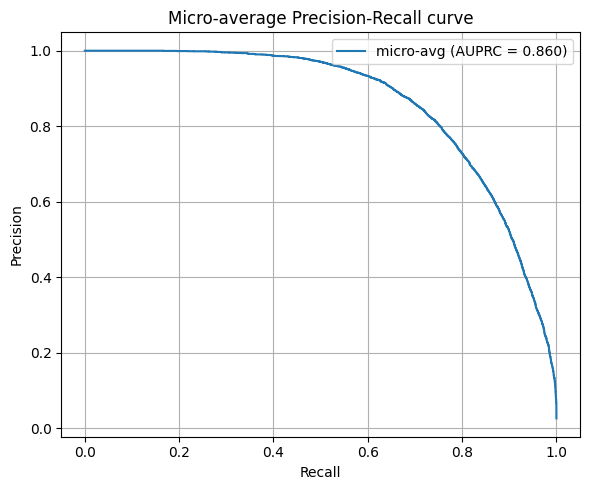


Micro‑average AUPRC: 0.8599


In [50]:
plt.figure(figsize=(6,5))
precision = dict()
recall = dict()
avg_precision = dict()

for c in range(num_classes):
    precision[c], recall[c], _ = precision_recall_curve(y_true_bin[:, c], probs[:, c])
    avg_precision[c] = average_precision_score(y_true_bin[:, c], probs[:, c])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(), probs.ravel()
)
avg_precision["micro"] = average_precision_score(
    y_true_bin, probs, average="micro"
)

plt.plot(recall["micro"], precision["micro"], label=f"micro‑avg (AUPRC = {avg_precision['micro']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Micro‑average Precision‑Recall curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nMicro‑average AUPRC: {avg_precision['micro']:.4f}")

## Final conclusion

| Metric                       | Score       |
| ---------------------------- | ----------- |
| **Best validation accuracy** | **91 %**    |
| **Top-1 / Top-3 accuracy**   | 0.77 / 0.92 |
| **Micro-avg AUPRC**          | 0.86        |
| **Macro-avg ROC-AUC**        | 0.99        |
| **Weighted-avg F1**          | 0.76        |

### Highlights

- Model is highly separable overall (AUC ~ 0.99) and places the correct class within its top-3 guesses 92 % of the time.
- Strong performance on Orange HLB, Soybean healthy, Grape leaf blight (F1 > 0.89, recall > 0.90).
- Weak spots remain for several tomato diseases where recall < 0.60.
